In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
###### Pip Install ######

# !pip install -qq torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install torchtext==0.9.1
!pip install -qq wandb timm==0.3.2 six tensorboardX

Looking in links: https://download.pytorch.org/whl/lts/1.8/torch_lts.html
     |█████████████▌                  | 834.1 MB 1.5 MB/s eta 0:13:11tcmalloc: large alloc 1147494400 bytes == 0x202e000 @  0x7fb9210f6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████               | 1055.7 MB 1.3 MB/s eta 0:11:36tcmalloc: large alloc 1434370048 bytes == 0x46684000 @  0x7fb9210f6615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████▋          | 1336.2 MB 1.3 MB/s eta 0:08:27tcmalloc: large alloc 1792966656 byt

In [3]:
###### Check for GPU availability ######

import torch
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device = {device}')

Setup complete. Using torch 1.8.1+cu111 (Tesla T4)
device = cuda


In [4]:
###### Libraries ######

import sys
import os
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
import torchvision.transforms as T
import timm

In [5]:
###### Helpers ######

def function():
  pass

In [6]:
###### Directories ######

dir = '/content/drive/MyDrive/a2/Image-Classification-ConvNeXt' # Change your working directory here
train_dir = os.path.join(dir, 'train')
test_dir = os.path.join(dir, 'test_images_updated')

# model_ckpt = os.path.join(dir, 'model_ckpt', 'checkpoint-best.pth')
# model_ckpt = os.path.join(dir, '10epoch_64batchsize_checkpoint-best.pth')
model_ckpt = os.path.join(dir, '20epoch_128batchsize_checkpoint-best.pth')
# model_ckpt = os.path.join(dir, 'resume_20epoch_128batchsize_checkpoint-best.pth') 
# model_ckpt = os.path.join(dir, '50epoch_128batchsize_checkpoint-best.pth')

# ConvNeXt Architecture

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm.models.layers import trunc_normal_, DropPath
from timm.models.registry import register_model

class Block(nn.Module):
    r""" ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    We use (2) as we find it slightly faster in PyTorch
    
    Args:
        dim (int): Number of input channels.
        drop_path (float): Stochastic depth rate. Default: 0.0
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
    """
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    r""" ConvNeXt
        A PyTorch impl of : `A ConvNet for the 2020s`  -
          https://arxiv.org/pdf/2201.03545.pdf
    Args:
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        depths (tuple(int)): Number of blocks at each stage. Default: [3, 3, 9, 3]
        dims (int): Feature dimension at each stage. Default: [96, 192, 384, 768]
        drop_path_rate (float): Stochastic depth rate. Default: 0.
        layer_scale_init_value (float): Init value for Layer Scale. Default: 1e-6.
        head_init_scale (float): Init scaling value for classifier weights and biases. Default: 1.
    """
    def __init__(self, in_chans=3, num_classes=92, # Change to 92 classes
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

class LayerNorm(nn.Module):
    r""" LayerNorm that supports two data formats: channels_last (default) or channels_first. 
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with 
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs 
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


model_urls = {
    "convnext_tiny_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth",
    "convnext_small_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_small_1k_224_ema.pth",
    "convnext_base_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth",
    "convnext_large_1k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_1k_224_ema.pth",
    "convnext_base_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_224.pth",
    "convnext_large_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_large_22k_224.pth",
    "convnext_xlarge_22k": "https://dl.fbaipublicfiles.com/convnext/convnext_xlarge_22k_224.pth",
}

@register_model
def convnext_tiny(pretrained=False, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], **kwargs)
    if pretrained:
        url = model_urls['convnext_tiny_1k']
        checkpoint = torch.hub.load_state_dict_from_url(url=url, map_location="cpu", check_hash=True)
        model.load_state_dict(checkpoint["model"])
    return model

In [8]:
model = convnext_tiny()
model

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU()
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [9]:
!ls /content/drive/MyDrive/CS424\ -\ IP/a2/Image-Classification-ConvNeXt/model_ckpt
# /content/drive/MyDrive/CS424 - IP/a2/Image-Classification-ConvNeXt/model_ckpt/checkpoint-best.pth

ls: cannot access '/content/drive/MyDrive/CS424 - IP/a2/Image-Classification-ConvNeXt/model_ckpt': No such file or directory


In [10]:
checkpoint = torch.load(model_ckpt, map_location=torch.device('cpu'))

In [11]:
weights_dict = checkpoint['model']
weights_dict.keys()

odict_keys(['downsample_layers.0.0.weight', 'downsample_layers.0.0.bias', 'downsample_layers.0.1.weight', 'downsample_layers.0.1.bias', 'downsample_layers.1.0.weight', 'downsample_layers.1.0.bias', 'downsample_layers.1.1.weight', 'downsample_layers.1.1.bias', 'downsample_layers.2.0.weight', 'downsample_layers.2.0.bias', 'downsample_layers.2.1.weight', 'downsample_layers.2.1.bias', 'downsample_layers.3.0.weight', 'downsample_layers.3.0.bias', 'downsample_layers.3.1.weight', 'downsample_layers.3.1.bias', 'stages.0.0.gamma', 'stages.0.0.dwconv.weight', 'stages.0.0.dwconv.bias', 'stages.0.0.norm.weight', 'stages.0.0.norm.bias', 'stages.0.0.pwconv1.weight', 'stages.0.0.pwconv1.bias', 'stages.0.0.pwconv2.weight', 'stages.0.0.pwconv2.bias', 'stages.0.1.gamma', 'stages.0.1.dwconv.weight', 'stages.0.1.dwconv.bias', 'stages.0.1.norm.weight', 'stages.0.1.norm.bias', 'stages.0.1.pwconv1.weight', 'stages.0.1.pwconv1.bias', 'stages.0.1.pwconv2.weight', 'stages.0.1.pwconv2.bias', 'stages.0.2.gamma', 

In [12]:
model.load_state_dict(weights_dict)

<All keys matched successfully>

In [13]:
model.eval()

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU()
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


# Test

In [14]:
# Define transforms for test
import torchvision.transforms as T
from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

NORMALIZE_MEAN = IMAGENET_DEFAULT_MEAN
NORMALIZE_STD = IMAGENET_DEFAULT_STD
SIZE = 256

# Here we resize smaller edge to 256, no center cropping
transforms = [
              T.Resize(SIZE, interpolation=T.InterpolationMode.BICUBIC),
              T.ToTensor(),
              # T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD)
              T.Normalize((0.5,), (0.5,))
              ]

transforms = T.Compose(transforms)

In [15]:
json_dir = os.path.join(dir, 'label_to_words.json')
labels = json.load(open(json_dir))
labels

{'0': '000000',
 '1': '000001',
 '10': '000010',
 '11': '000011',
 '12': '000012',
 '13': '000013',
 '14': '000014',
 '15': '000015',
 '16': '000016',
 '17': '000017',
 '18': '000018',
 '19': '000019',
 '2': '000002',
 '20': 'a_Capitol',
 '21': 'a_Chijmes',
 '22': 'a_Cityhall',
 '23': 'a_CoffeeShop',
 '24': 'a_HDB',
 '25': 'a_SMUadmin',
 '26': 'a_Underground',
 '27': 'a_cemetry',
 '28': 'a_church',
 '29': 'a_law',
 '3': '000003',
 '30': 'a_library',
 '31': 'a_museum',
 '32': 'a_scis',
 '33': 'americano',
 '34': 'bak_kwa',
 '35': 'beef_noodles_soup',
 '36': 'boiled_clams',
 '37': 'boonthi',
 '38': 'braised_pig_skin',
 '39': 'braised_pig_trotter_with_mushroom',
 '4': '000004',
 '40': 'braised_pork_with_black_fungus',
 '41': 'cafe_coffee_with_milk',
 '42': 'chasoba',
 '43': 'chicken_and_mushroom_noodles_soup',
 '44': 'chicken_feet_noodles_soup',
 '45': 'chicken_macaroni_soup',
 '46': 'cooked_jellyfish_with_sesame_seed',
 '47': 'crab_stick',
 '48': 'curry_udon',
 '49': 'dry_chicken_feet_no

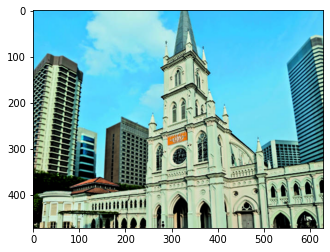

In [16]:
# Read images using PIL
image_dir = os.path.join(test_dir, '1194.jpg')
img = PIL.Image.open(image_dir)
plt.imshow(img)
img_tensor = transforms(img).unsqueeze(0).to(device)

if img_tensor.shape[1] == 1: # transform 1-channel (greyscale) tensor to 3 channels
  img_tensor = img_tensor.expand(-1, 3, -1, -1)
elif img_tensor.shape[1] == 4: # transform 4-channel (RGBAlpha) tensor to 3 channels
  img_tensor = img_tensor[ :, :3, :, : ]

In [17]:
# img_tensor = img_tensor[ :, :1, :, : ]
img_tensor = img_tensor.expand(-1, 3, -1, -1)
img_tensor.shape

torch.Size([1, 3, 256, 341])

In [18]:
model.cuda() # if running on gpu

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU()
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)


In [19]:
# inference
top_n_inference = 5 # change parameter here
output = torch.softmax(model(img_tensor), dim=1)
top5 = torch.topk(output, k=top_n_inference)
top5_prob = top5.values[0]
top5_prob_arr = top5_prob.cpu().detach().numpy()
top5_indices = top5.indices[0]
top5_indices_arr = top5_indices.cpu().numpy()
for i in range(top_n_inference):
  category = top5_indices_arr[i]
  label = labels[str(category)]
  prob = np.round(top5_prob_arr[i]*100, 4)
  print(f'Pred {i} ==> Category: {category}, Label: {label}, Probability: {prob}%', end=' ------- ')

Pred 0 ==> Category: 21, Label: a_Chijmes, Probability: 85.9692% ------- Pred 1 ==> Category: 18, Label: 000018, Probability: 0.3206% ------- Pred 2 ==> Category: 6, Label: 000006, Probability: 0.3175% ------- Pred 3 ==> Category: 60, Label: instant_coffee, Probability: 0.2624% ------- Pred 4 ==> Category: 0, Label: 000000, Probability: 0.2617% ------- 

21 a_Chijmes 85.97%


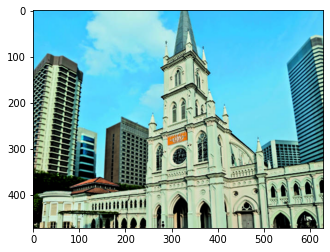

In [20]:
# inference
output = torch.softmax(model(img_tensor), dim=1)
top1 = torch.topk(output, k=1)
top1_prob = top1.values[0]
top1_indices = top1.indices[0]
category = int(top1_indices[0])
label = labels[str(category)]
prob = "{:.2f}%".format(float(top1_prob[0])*100)
print(category, label, prob)

plt.imshow(img)

In [21]:
test_image_names = sorted(os.listdir(test_dir))
len(test_image_names)

4770

Pred 0 ==> Category: 39, Label: braised_pig_trotter_with_mushroom, Probability: 89.0563% ------- Pred 1 ==> Category: 70, Label: pig_trotter_in_vinegar, Probability: 0.8615% ------- Pred 2 ==> Category: 57, Label: fried_vegetable_samosa, Probability: 0.2021% ------- Pred 3 ==> Category: 63, Label: kopi_o, Probability: 0.1879% ------- Pred 4 ==> Category: 61, Label: jalebi, Probability: 0.1831% ------- 

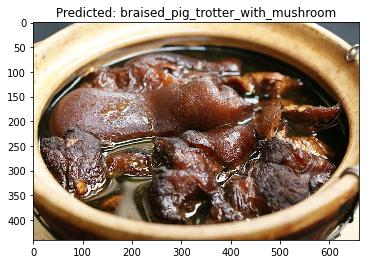

Pred 0 ==> Category: 6, Label: 000006, Probability: 88.5261% ------- Pred 1 ==> Category: 22, Label: a_Cityhall, Probability: 0.1984% ------- Pred 2 ==> Category: 45, Label: chicken_macaroni_soup, Probability: 0.1731% ------- Pred 3 ==> Category: 41, Label: cafe_coffee_with_milk, Probability: 0.1689% ------- Pred 4 ==> Category: 66, Label: lotus_paste_with_salted_egg_pastry, Probability: 0.1678% ------- 

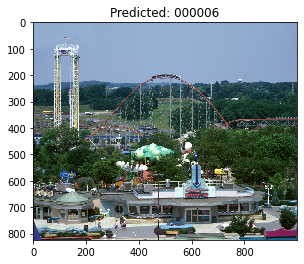

Pred 0 ==> Category: 49, Label: dry_chicken_feet_noodles, Probability: 87.831% ------- Pred 1 ==> Category: 43, Label: chicken_and_mushroom_noodles_soup, Probability: 0.2498% ------- Pred 2 ==> Category: 63, Label: kopi_o, Probability: 0.2181% ------- Pred 3 ==> Category: 78, Label: roasted_pork_belly, Probability: 0.2133% ------- Pred 4 ==> Category: 52, Label: espresso, Probability: 0.2026% ------- 

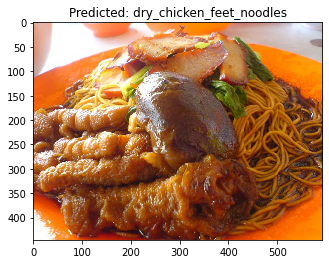

Pred 0 ==> Category: 2, Label: 000002, Probability: 89.4848% ------- Pred 1 ==> Category: 26, Label: a_Underground, Probability: 0.5284% ------- Pred 2 ==> Category: 32, Label: a_scis, Probability: 0.2465% ------- Pred 3 ==> Category: 30, Label: a_library, Probability: 0.2352% ------- Pred 4 ==> Category: 35, Label: beef_noodles_soup, Probability: 0.204% ------- 

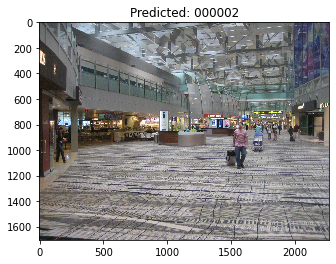

Pred 0 ==> Category: 63, Label: kopi_o, Probability: 74.7906% ------- Pred 1 ==> Category: 64, Label: local_coffee_with_milk, Probability: 8.0538% ------- Pred 2 ==> Category: 86, Label: steamed_minced_pork_with_fish_mushroom_and_preserved_veg, Probability: 0.4391% ------- Pred 3 ==> Category: 54, Label: fishball, Probability: 0.3417% ------- Pred 4 ==> Category: 50, Label: dry_duck_noodles, Probability: 0.3345% ------- 

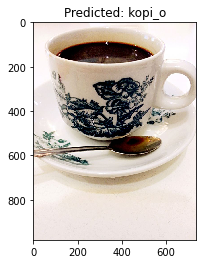

Pred 0 ==> Category: 32, Label: a_scis, Probability: 87.5966% ------- Pred 1 ==> Category: 33, Label: americano, Probability: 0.3878% ------- Pred 2 ==> Category: 30, Label: a_library, Probability: 0.293% ------- Pred 3 ==> Category: 63, Label: kopi_o, Probability: 0.2755% ------- Pred 4 ==> Category: 42, Label: chasoba, Probability: 0.2276% ------- 

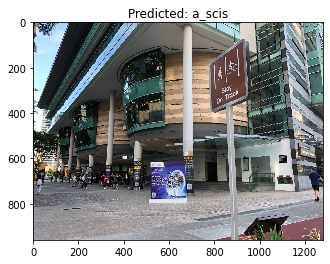

Pred 0 ==> Category: 71, Label: pineapple_tart, Probability: 89.2214% ------- Pred 1 ==> Category: 72, Label: pong_piah, Probability: 0.3097% ------- Pred 2 ==> Category: 86, Label: steamed_minced_pork_with_fish_mushroom_and_preserved_veg, Probability: 0.2255% ------- Pred 3 ==> Category: 80, Label: sa_kei_ma, Probability: 0.2104% ------- Pred 4 ==> Category: 87, Label: stir_fried_pork, Probability: 0.2089% ------- 

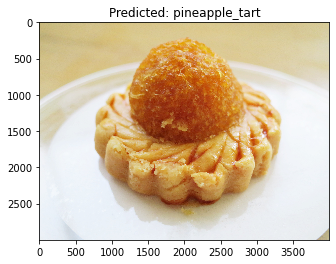

Pred 0 ==> Category: 70, Label: pig_trotter_in_vinegar, Probability: 91.4457% ------- Pred 1 ==> Category: 38, Label: braised_pig_skin, Probability: 0.4475% ------- Pred 2 ==> Category: 65, Label: lor_bak_nonya_style_simmered_pork, Probability: 0.3617% ------- Pred 3 ==> Category: 77, Label: red_wine_chicken_mee_sua, Probability: 0.2414% ------- Pred 4 ==> Category: 4, Label: 000004, Probability: 0.1363% ------- 

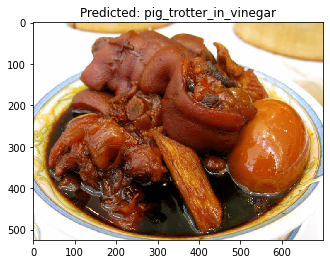

Pred 0 ==> Category: 8, Label: 000008, Probability: 89.6382% ------- Pred 1 ==> Category: 0, Label: 000000, Probability: 0.8529% ------- Pred 2 ==> Category: 11, Label: 000011, Probability: 0.5412% ------- Pred 3 ==> Category: 12, Label: 000012, Probability: 0.2851% ------- Pred 4 ==> Category: 3, Label: 000003, Probability: 0.2215% ------- 

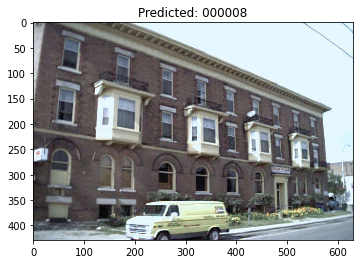

Pred 0 ==> Category: 23, Label: a_CoffeeShop, Probability: 92.2324% ------- Pred 1 ==> Category: 20, Label: a_Capitol, Probability: 0.7179% ------- Pred 2 ==> Category: 72, Label: pong_piah, Probability: 0.3213% ------- Pred 3 ==> Category: 85, Label: soya_sauce_chicken_noodles, Probability: 0.2528% ------- Pred 4 ==> Category: 21, Label: a_Chijmes, Probability: 0.2221% ------- 

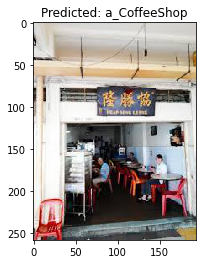

In [22]:
# Sample 10 predictions
for i in range(10):
  img_name = random.choice(test_image_names)
  img_dir = os.path.join(test_dir, img_name)
  img = PIL.Image.open(img_dir)
  img_tensor = transforms(img).unsqueeze(0).to(device)

  if img_tensor.shape[1] == 1: # transform 1-channel (greyscale) tensor to 3 channels
    img_tensor = img_tensor.expand(-1, 3, -1, -1)
  elif img_tensor.shape[1] == 4: # transform 4-channel (RGBAlpha) tensor to 3 channels
    img_tensor = img_tensor[ :, :3, :, : ]

  # inference
  top_n_inference = 5 # change parameter here
  output = torch.softmax(model(img_tensor), dim=1)
  top5 = torch.topk(output, k=top_n_inference)
  top5_prob = top5.values[0]
  top5_prob_arr = top5_prob.cpu().detach().numpy()
  top5_indices = top5.indices[0]
  top5_indices_arr = top5_indices.cpu().numpy()
  for i in range(top_n_inference):
    category = top5_indices_arr[i]
    label = labels[str(category)]
    prob = np.round(top5_prob_arr[i]*100, 4)
    print(f'Pred {i} ==> Category: {category}, Label: {label}, Probability: {prob}%', end=' ------- ')

  # plot image
  plt.imshow(img)
  plt.imshow(img, interpolation='nearest')
  plt.title(f'Predicted: {labels[str(top5_indices_arr[0])]}')
  plt.show()

# Submission_top1.csv

In [ ]:
id_array = []
category_array = []
for i in range(len(test_image_names)):
    img_name = test_image_names[i]
    print(img_name)
    id = int(img_name.split('.')[0])

    img_dir = os.path.join(test_dir, img_name)
    img = PIL.Image.open(img_dir)
    img_tensor = transforms(img).unsqueeze(0).to(device)

    if img_tensor.shape[1] == 1: # transform 1-channel (greyscale) tensor to 3 channels
      img_tensor = img_tensor.expand(-1, 3, -1, -1)
    elif img_tensor.shape[1] == 4: # transform 4-channel (RGBAlpha) tensor to 3 channels
      img_tensor = img_tensor[ :, :3, :, : ]

    ## inference ##
    output = torch.softmax(model(img_tensor), dim=1)
    top1 = torch.topk(output, k=1)
    top1_prob = top1.values[0]
    top1_indices = top1.indices[0]
    category = int(top1_indices[0])
    # label = labels[str(category)]
    # prob = "{:.2f}%".format(float(top1_prob[0])*100)

    id_array.append(id)
    category_array.append(category)

res = pd.DataFrame(zip(id_array, category_array), columns=["id", "category"])
res.to_csv('submission_top1.csv', index=None)

0.jpg
1.jpg
10.jpg
100.jpg
1000.jpg
1001.jpg
1002.JPG
1003.jpg
1004.jpg
1005.jpg
1006.jpg
1007.JPG
1008.jpg
1009.jpg
101.jpg
1010.jpg
1011.jpg
1012.jpg
1013.jpg
1014.jpg
1015.jpg
1016.JPG
1017.jpg
1018.jpg
1019.jpg
102.jpg
1020.jpg
1021.jpg
1022.jpg
1023.jpg
1024.jpg
1025.jpeg
1026.jpg
1027.jpg
1028.jpg
1029.jpg
103.jpg
1030.jpeg
1031.jpg
1032.jpg
1033.JPG
1034.jpg
1035.jpg
1036.jpg
1037.jpg
1038.jpg
1039.jpg
104.jpg
1040.jpg
1041.jpg
1042.jpg
1043.jpg
1044.jpg
1045.jpg
1046.JPG
1047.jpg
1048.jpg
1049.jpg
105.jpg
1050.jpg
1051.jpg
1052.jpg
1053.jpg
1054.jpg
1055.jpg
1056.jpg
1057.jpg
1058.jpg
1059.jpg
106.jpg
1060.jpg
1061.JPG
1062.jpg
1063.jpeg
1064.jpg
1065.jpg
1066.JPG
1067.JPEG
1068.jpg
1069.jpg
107.JPG
1070.jpg
1071.jpg
1072.jpg
1073.JPG
1074.jpg
1075.jpg
1076.jpg
1077.jpg
1078.jpeg
1079.jpg
108.JPG
1080.jpg
1081.JPG
1082.jpg
1083.jpg
1084.jpg
1085.JPG
1086.jpg
1087.jpeg
1088.jpg
1089.jpg
109.jpg
1090.jpg
1091.jpg
1092.jpeg
1093.jpg
1094.JPG
1095.jpg
1096.jpg
1097.jpg
1098.jpeg
10

# Submission_top5.csv

In [23]:
top_n_inference = 5 # change parameter here and add cat_array
id_array = []
cat1_array = []
cat2_array = []
cat3_array = []
cat4_array = []
cat5_array = []

for i in range(len(test_image_names)):
    img_name = test_image_names[i]
    print(img_name)
    id = int(img_name.split('.')[0])

    img_dir = os.path.join(test_dir, img_name)
    img = PIL.Image.open(img_dir)
    img_tensor = transforms(img).unsqueeze(0).to(device)

    if img_tensor.shape[1] == 1: # transform 1-channel (greyscale) tensor to 3 channels
      img_tensor = img_tensor.expand(-1, 3, -1, -1)
    elif img_tensor.shape[1] == 4: # transform 4-channel (RGBAlpha) tensor to 3 channels
      img_tensor = img_tensor[ :, :3, :, : ]

    ## inference ##
    output = torch.softmax(model(img_tensor), dim=1)
    top5 = torch.topk(output, k=top_n_inference)
    top5_prob = top5.values[0]
    top5_prob_arr = top5_prob.cpu().detach().numpy()
    top5_indices = top5.indices[0]
    top5_indices_arr = top5_indices.cpu().numpy()
    # for i in range(top_n_inference):
    #   category = top5_indices_arr[i]
    #   label = labels[str(category)]
    #   prob = np.round(top5_prob_arr[i]*100, 4)
    #   print(f'Pred {i} ==> Category: {category}, Label: {label}, Probability: {prob}%', end=' ------- ')

    id_array.append(id)
    cat1_array.append(top5_indices_arr[0])
    cat2_array.append(top5_indices_arr[1])
    cat3_array.append(top5_indices_arr[2])
    cat4_array.append(top5_indices_arr[3])
    cat5_array.append(top5_indices_arr[4])

res = pd.DataFrame(zip(id_array, cat1_array, cat2_array, cat3_array, cat4_array, cat5_array), columns=["id", "category1", "category2", "category3", "category4", "category5"])
res.to_csv('submission_top5.csv', index=None)

0.jpg
1.jpg
10.jpg
100.jpg
1000.jpg
1001.jpg
1002.JPG
1003.jpg
1004.jpg
1005.jpg
1006.jpg
1007.JPG
1008.jpg
1009.jpg
101.jpg
1010.jpg
1011.jpg
1012.jpg
1013.jpg
1014.jpg
1015.jpg
1016.JPG
1017.jpg
1018.jpg
1019.jpg
102.jpg
1020.jpg
1021.jpg
1022.jpg
1023.jpg
1024.jpg
1025.jpeg
1026.jpg
1027.jpg
1028.jpg
1029.jpg
103.jpg
1030.jpeg
1031.jpg
1032.jpg
1033.JPG
1034.jpg
1035.jpg
1036.jpg
1037.jpg
1038.jpg
1039.jpg
104.jpg
1040.jpg
1041.jpg
1042.jpg
1043.jpg
1044.jpg
1045.jpg
1046.JPG
1047.jpg
1048.jpg
1049.jpg
105.jpg
1050.jpg
1051.jpg
1052.jpg
1053.jpg
1054.jpg
1055.jpg
1056.jpg
1057.jpg
1058.jpg
1059.jpg
106.jpg
1060.jpg
1061.JPG
1062.jpg
1063.jpeg
1064.jpg
1065.jpg
1066.JPG
1067.JPEG
1068.jpg
1069.jpg
107.JPG
1070.jpg
1071.jpg
1072.jpg
1073.JPG
1074.jpg
1075.jpg
1076.jpg
1077.jpg
1078.jpeg
1079.jpg
108.JPG
1080.jpg
1081.JPG
1082.jpg
1083.jpg
1084.jpg
1085.JPG
1086.jpg
1087.jpeg
1088.jpg
1089.jpg
109.jpg
1090.jpg
1091.jpg
1092.jpeg
1093.jpg
1094.JPG
1095.jpg
1096.jpg
1097.jpg
1098.jpeg
10